In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
if GPUs:
    gpu = GPUs[0]

def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
    if GPUs:
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil * 100, gpu.memoryTotal))
    else:
        print("No GPU available.")

printm()

  Preparing metadata (setup.py) ... done
Gen RAM Free: 11.8 GB  | Proc size: 99.4 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB


# 1. Setup

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive/"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Mounted at /content/drive/


## 1.1 Using Colab GPU for training

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2 Install Hugging Face library

In [ ]:
!pip install transformers --q

# 2. Load Dataset

In [ ]:
# dict mapping
label2num = {
    'Politik': 0,
    'Sosial Budaya': 1,
    'Pertahanan dan Keamanan': 2,
    'Ideologi': 3,
    'Ekonomi': 4,
    'Sumber Daya Alam': 5,
    'Demografi': 6,
    'Geografi': 7
}

In [ ]:
! pip install openpyxl
import pandas as pd


train = pd.read_excel("/content/drive/MyDrive/dataset_penyisihan_bdc_2024.xlsx")

test = pd.read_excel("/content/drive/MyDrive/dataset_unlabeled_penyisihan_bdc_2024.xlsx")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
# encode label
train.label = train.label.map(label2num)

# Data Cleansing

In [ ]:
# install library symspellpy
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187487 sha256=0db7a9ff0cfa37ddb56574ec8779271330dd477e1e98d9cbb0eeda4748483c45
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [ ]:
from symspellpy import SymSpell, Verbosity

# initialize
sym_spell = SymSpell()

# create dictionary
path_corpus = "/content/drive/MyDrive/Satria Data 2024/wiki.txt"
sym_spell.create_dictionary(path_corpus)

True

In [ ]:
! pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import nltk
import re
import collections
nltk.download('punkt')

def get_frequent_word(df, column):
    text = " ".join(list(df[column].str.lower()))
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    d_word_freq = pd.DataFrame(data = {'word': list(word_count.keys()), 'freq': list(word_count.values())})

    return d_word_freq

def cleansing(text, stopword = None):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?://\S+', '', text)

    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    text = re.sub(r'\b[A-Za-z0-9_]{10,}\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)

    word_list = word_tokenize(text.lower())
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]

    corrected_words = [sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1)[0].term if sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1) else word for word in word_list]

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_words = [stemmer.stem(word) for word in corrected_words]


    if stopword == None:
        text = ' '.join(stemmed_words)
    #else:
    #    word_list = [word for word in stemmed_words if word not in stopword]
    #    text = ' '.join(word_list)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(train))):
    train.loc[i, 'text_cleansing'] = cleansing(train.loc[i, 'text'])

for i in tqdm(range(len(test))):
    test.loc[i, 'text_cleansing'] = cleansing(test.loc[i, 'Text'])

100%|██████████| 1000/1000 [11:32<00:00,  1.44it/s]


In [ ]:
train.to_excel("/content/drive/MyDrive/Satria Data 2024/train_with_stopwords.xlsx")
test.to_excel("/content/drive/MyDrive/Satria Data 2024/test_with_stopwords.xlsx")

In [ ]:
# Get frekuensi kemunculan kata
d_w_f = get_frequent_word(train, column='text_cleansing')
# Check alphanumeric
d_w_f['is_alnum'] = d_w_f.word.str.isalnum()
# select only alphanumeric word (ignore punctuation)
d_w_f_selected = d_w_f[d_w_f['is_alnum'] == True].sort_values(by = 'freq', ascending = False)
print(d_w_f_selected.head(15))
print(d_w_f_selected.tail(15))

        word  freq  is_alnum
4        dan  2962      True
181     yang  2678      True
12     anies  2338      True
94    ganjar  1971      True
1    prabowo  1838      True
3      untuk  1359      True
2        ini  1274      True
35       pak  1199      True
210  pranowo  1048      True
18      jadi   978      True
145   mahfud   939      True
160   dengan   913      True
554     kita   864      True
123      itu   834      True
120     dari   808      True
          word  freq  is_alnum
4841     batal     1      True
4891    avowed     1      True
4893   visions     1      True
4894     antam     1      True
4895   mohamed     1      True
4897       pie     1      True
4883   kontras     1      True
4884  ngeklaim     1      True
4885   tanding     1      True
4889    sampah     1      True
4880  standout     1      True
4881  jogednya     1      True
4866        kw     1      True
4869   wkwkwkw     1      True
4840     yogja     1      True


In [ ]:
# Create stopwords list
stopwords = list(d_w_f_selected[(d_w_f_selected['freq'] > 500) | (d_w_f_selected['freq'] < 2)].word)
print(stopwords[:10])

['dan', 'yang', 'anies', 'ganjar', 'prabowo', 'untuk', 'ini', 'pak', 'pranowo', 'jadi']


In [ ]:
def remove_stopwords(text, stopword=None):
  word_list = word_tokenize(text.lower())
  word_list = [word for word in word_list if len(word) > 2]
  word_list = [word for word in word_list if word.isalnum()]
  word_list = [word for word in word_list if word not in stopword]
  text = ' '.join(word_list)
  return text

In [ ]:
for i in tqdm(range(len(train))):
    train.loc[i, 'text_cleansing2'] = remove_stopwords(train.loc[i, 'text_cleansing'], stopword=stopwords)

for i in tqdm(range(len(test))):
    test.loc[i, 'text_cleansing2'] = remove_stopwords(test.loc[i, 'text_cleansing'], stopword=stopwords)

100%|██████████| 1000/1000 [00:01<00:00, 632.48it/s]


In [ ]:
train.to_excel("/content/drive/MyDrive/Satria Data 2024/train_without_stopwords.xlsx")
test.to_excel("/content/drive/MyDrive/Satria Data 2024/test_without_stopwords.xlsx")

## Load Dataset Cleansing

In [ ]:
! pip install openpyxl
import pandas as pd

train = pd.read_excel("/content/drive/MyDrive/SD 2024/train_without_stopwords.xlsx")

test = pd.read_excel("/content/drive/MyDrive/SD 2024/test_without_stopwords.xlsx")

In [ ]:
train = train.dropna()

In [ ]:
train.isna().sum()

Unnamed: 0         0
text               0
label              0
text_cleansing     0
text_cleansing2    0
dtype: int64

In [ ]:
# Training data only use 4000 sentences
sentences = train.text_cleansing2.values
labels = train.label.values

# Testing data only use 1000 sentence
test_sentences = test.text_cleansing2.values

# 3. Tokenization & Input Formatting

## 3.1 BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
print('done')

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

done


## 3.2 Required Formatting

We are required to:

1.   Tambah special tokens di awal dan akhir setiap kalimat
2.   Pad or truncate semua kalimat ke length tertentu
3.   Prepare "attention mask"

### Special Tokens


**`[SEP]`**

Pada akhir setiap kalimat, kita perlu menambahkan `[SEP]` token.

**`[CLS]`**

Untuk classification tasks, kita harus menambahkan `[CLS]` token ke setiap awal kalimat.

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))



### Sentence Length & Attention Mask

Panjang kalimat dalam dataset sangat bervariasi, jadi gimana cara-nya BERT handle ini ?

BERT punya 2 batasan :
1. Semua kalimat harus di pad atau truncate menjadi satu fixed length
2. Max sentence length is 512 tokens

Padding menggunakan special token `[PAD]`

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

"Attention Mask" adalah array yang terdiri dari '1' dan '0' dimana '1' mengindikasikan token tsb adalah padding dan '0' yang bukan. Mask ini memberitahu  pada "Self-Attention" pada BERT untuk tidak memasukkan token `[PAD]` ini saat menginterpretasikan kalimat





## 3.3 Tokenize Dataset

In [ ]:
import statistics
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  30.15033072760072
Median length =  22


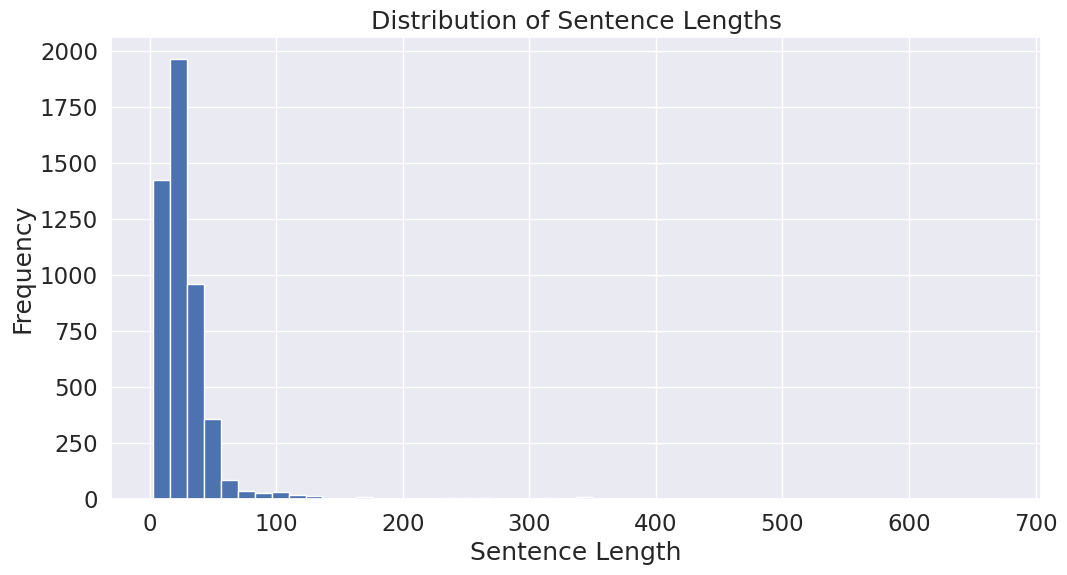

50th percentile (median): 22.0
75th percentile: 34.0
90th percentile: 47.0
95th percentile: 60.0
99th percentile: 204.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of sentence lengths
plt.hist(sent_length, bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

# Calculate percentiles
percentiles = np.percentile(sent_length, [50, 75, 90, 95, 99])
print(f'50th percentile (median): {percentiles[0]}')
print(f'75th percentile: {percentiles[1]}')
print(f'90th percentile: {percentiles[2]}')
print(f'95th percentile: {percentiles[3]}')
print(f'99th percentile: {percentiles[4]}')

Max length di set menjadi 50.

Fungsi `tokenizer.encode_plus` melakukan beberapa langkah :

1. Split kalimat jadi token.
2. Tambah special token (`[CLS]` and `[SEP]`)
3. Mapping token menjadi ID
4. Pad atau truncate semua kalimat menjadi same length.
5. Buat attention mask

Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  kunjung proyek bantu air bersih lima titik subianto
Token IDs: tensor([   101,  13158,  30425, 102384,  11915,  10991,  12566,  10347,  15241,
         10237,  36686,  57073,  13987,  24096,  10133,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0])


<ipython-input-85-5f896366af58>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


## 3.4. Training & Validation Split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,240 training samples
  749 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

## 4.1. BertForSequenceClassification



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 8,
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

Show model parameters

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Untuk fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 3

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8,
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=int(0.1*total_steps),
                                            num_training_steps=total_steps)

`get_linear_schedule_with_warmup` function :
Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period.

## 4.3. Training Loop

**Training:**
- Unpack our data inputs and labels
- Load data to GPU
- Clear out the gradients calculated in the previous pass.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data to GPU
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Ready to kick off the training!

In [ ]:
# List to store training statistics
training_stats = []

# Measure total training time
total_t0 = time.time()

# Training loop
for epoch_i in range(0, epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f"  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.")

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs[0]
        logits = outputs[1]

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs[0]
            logits = outputs[1]

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    training_stats.append({
        'Epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
        'Validation Accuracy': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")

# Optionally, save the model and the tokenizer
# model.save_pretrained('./model_save')
# tokenizer.save_pretrained('./model_save')



======== Epoch 1 / 3 ========
Training...
  Batch    20  of    133.    Elapsed: 0:00:06.
  Batch    40  of    133.    Elapsed: 0:00:12.
  Batch    60  of    133.    Elapsed: 0:00:17.
  Batch    80  of    133.    Elapsed: 0:00:23.
  Batch   100  of    133.    Elapsed: 0:00:29.
  Batch   120  of    133.    Elapsed: 0:00:35.

  Average training loss: 1.35
  Training epoch took: 0:00:39

Running Validation...
  Accuracy: 0.65
  Validation Loss: 1.11
  Validation took: 0:00:02

======== Epoch 2 / 3 ========
Training...
  Batch    20  of    133.    Elapsed: 0:00:06.
  Batch    40  of    133.    Elapsed: 0:00:11.
  Batch    60  of    133.    Elapsed: 0:00:17.
  Batch    80  of    133.    Elapsed: 0:00:23.
  Batch   100  of    133.    Elapsed: 0:00:28.
  Batch   120  of    133.    Elapsed: 0:00:34.

  Average training loss: 0.96
  Training epoch took: 0:00:38

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.95
  Validation took: 0:00:02

======== Epoch 3 / 3 ========
Training...
 

In [ ]:
# Optionally, save the model and the tokenizer
model.save_pretrained('./model_save')
tokenizer.save_pretrained('./model_save')

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'Epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
print(df_stats)

       Training Loss  Validation Loss  Validation Accuracy Training Time  \
Epoch                                                                      
1               1.35             1.11                 0.65       0:00:39   
2               0.96             0.95                 0.72       0:00:38   
3               0.79             0.94                 0.71       0:00:38   

      Validation Time  
Epoch                  
1             0:00:02  
2             0:00:02  
3             0:00:02  


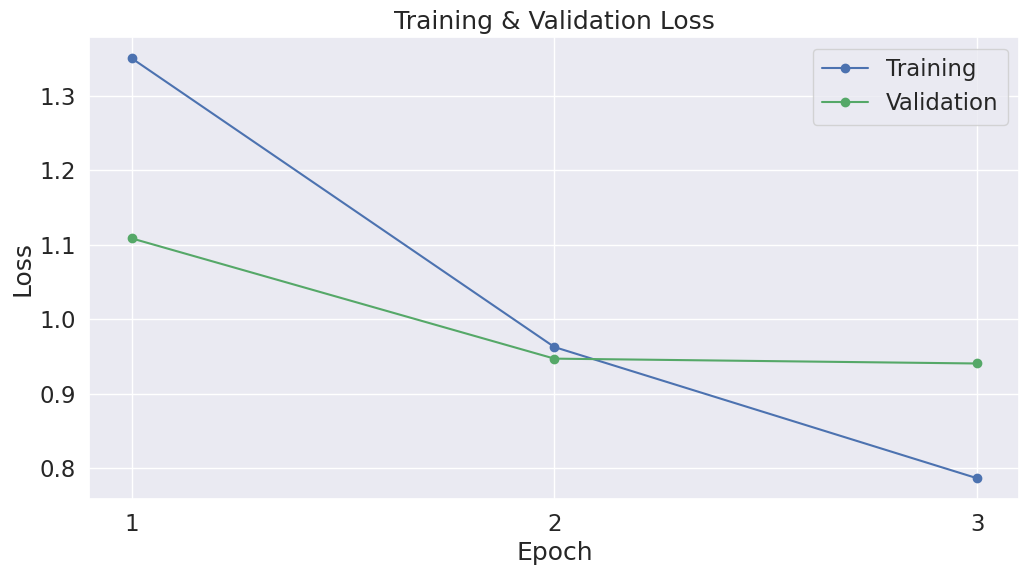

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure inline plotting is enabled for Jupyter Notebooks
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()


# 5. Performance On Test Set

### 5.1. Data Preparation

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
                        max_length=50,            # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,# Construct attn. masks.
                        return_tensors='pt',       # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


## 5.2. Evaluate on Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.append(logits)

# Flatten the predictions
flat_predictions = [item for sublist in predictions for item in sublist]

# Get the predicted class for each sentence
predicted_classes = np.argmax(flat_predictions, axis=1)

print(predicted_classes)

print('    DONE.')

Predicting labels for 1,000 test sentences...
[0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 4 0 0 0 4 1 4 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0
 0 4 0 1 0 0 0 2 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 2 0 0 1 0 0 5 0 2
 0 0 0 0 4 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 4 0 0 4 4 0 0 0 0 4 0
 4 0 0 2 1 0 0 4 4 4 4 0 0 0 0 0 0 0 2 5 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 5 0
 0 0 0 2 0 4 0 0 0 0 0 0 0 0 0 0 2 0 0 0 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 4 0 4 1 0 0 0 0 4 0 0 3
 0 0 0 0 0 4 0 4 0 0 0 0 4 0 0 0 0 0 0 4 4 1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 4 0 0 4 0 0 0 0 0 1 4 0 4 4 0 0 0 4 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 4 0
 2 0 4 0 0 0 0 1 0 0 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0 0 4 0
 2 0 0 0 0 0 0 0 0 0 0 0 4 0 0 3 0 1 0 0 0 4 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0
 0 0 5 0 0 1 0 0 4 0 0 0 0 0 0 0 4 1 0 0 0 0 0 0 5 1 0 0 0 0 0 0 0 1 4 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 4 1 0 3 0 0 0 0 0 0 0 0

In [ ]:
num2label = {v: k for k, v in label2num.items()}
predicted_labels = [num2label[pred] for pred in predicted_classes]

In [ ]:
result_df = test.copy()
result_df['Kelas'] = predicted_labels

In [ ]:
result_df

,Unnamed: 0,IDText,Text,text_cleansing,text_cleansing2,Kelas
0,0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,mau org negara ini bisa punya lagi buat ngelaw...,mau org negara punya lagi buat oligarki indo p...,Politik
1,1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo tanya soal hutang luar negeri dia jawa...,tanya soal hutang luar negeri dia jawab hutang...,Ekonomi
2,2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,ganjar pranowo itu beliau sosok yang nilai nil...,beliau sosok nilai nilai pancasila banyak sada...,Politik
3,3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa laku itu semua demi r...,gibran laku semua demi,Politik
4,4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru gak nyambung junjung elu etika tapi...,lah justru gak nyambung junjung elu etika tapi...,Politik
...,...,...,...,...,...,...
995,995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",bikin bangga deh mau tengah dari belanja dan b...,bikin bangga deh mau tengah belanja bumn buat ...,Politik
996,996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi belum pilpres besar hati rangkul pa...,jokowi belum pilpres besar hati rangkul pun de...,Politik
997,997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,baik remot nga usah ikut debat denga jelas mau...,baik remot nga usah ikut debat denga jelas mau...,Politik
998,998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,biasa rembuk atau jadi gaya ganjar sejak jadi ...,biasa rembuk atau gaya sejak gubernur jateng g...,Ekonomi


In [ ]:
submission = result_df[['IDText', 'Kelas']]

In [ ]:
submission.to_csv('/content/drive/MyDrive/SD 2024/SD2024040000011.csv', index=False, sep=',')

In [ ]:
# @title
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions)):
  total_accuracy += flat_accuracy(predictions[batch_num], true_labels[batch_num])

total_accuracy = total_accuracy/len(predictions)*100
print('Accuracy on test dataset:', total_accuracy)

# Saving Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'drive/My Drive/DSI/model/'

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to drive/My Drive/DSI/model/


('drive/My Drive/DSI/model/tokenizer_config.json',
 'drive/My Drive/DSI/model/special_tokens_map.json',
 'drive/My Drive/DSI/model/vocab.txt',
 'drive/My Drive/DSI/model/added_tokens.json')

# Load Model back from disk

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)